# ViewBox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Ambiente de trabalho: ViewBox
Primeiro definimos o tamanho do viewbox, na proporção de 16:9 a ser utilizado com as coordenadas:

* Left: 0 & Right: 1600
* Botton: 0 % Top: 900
* Near: 0 & Far: -100

In [ ]:
left = 0
right = 1600
bottom = 0
top = 900
near = 0
far = -100

vertices = np.array([
    [left, bottom, near],       # Vértice 0
    [right, bottom, near],      # Vértice 1
    [right, top, near],         # Vértice 2
    [left, top, near],          # Vértice 3
    [left, bottom, far],        # Vértice 4
    [right, bottom, far],       # Vértice 5
    [right, top, far],          # Vértice 6
    [left, top, far]            # Vértice 7
])

## O modelo
Para realizar as operaçoes de transformação será utilizado um Pirâmide

In [ ]:
def construir_piramide():
  arestas = [
    [0, 1], [1, 2], [2, 3], [3, 0],
    [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
  ]

  # Vértices do triângulo 3D centralizados no viewBox
  vertices = np.array([
      [400, 200, -50],    # Vértice 0
      [400, 200, 0],      # Vértice 1
      [1200, 200, -50],   # Vértice 2
      [1200, 200, 0],     # Vértice 3
      [800, 800, -50]     # Vértice 4
  ])

  piramide_arestas = [
      [0, 1],  [2, 0],
      [1, 3], [2, 3],
      [0, 4], [1, 4],
      [2, 4], [3, 4]
  ]

  return arestas, vertices, piramide_arestas

arestas, piramide_vertices, piramide_arestas = construir_piramide()

## Pirâmide no ViewBox



1.   Plotar a figura que será utilizada
2.   Seguido do ViewBox
3.   Por fim a pirâmide



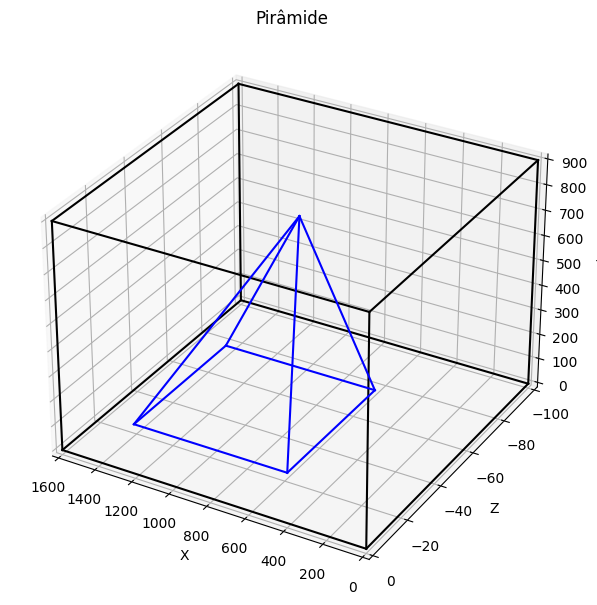

In [ ]:
figura = plt.figure(figsize=(16, 10))
eixo1 = figura.add_subplot(121, projection='3d')

def apresentar_box():
  for aresta in arestas:
    eixo1.plot(vertices[aresta, 0], vertices[aresta, 2], vertices[aresta, 1], color='black')

apresentar_box()

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]
    eixo1.plot(
        [v1[0], v2[0]],
        [v1[2], v2[2]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide'
    )
eixo1.set_xlim(0, 1600)
eixo1.set_ylim(0, -100)
eixo1.set_zlim(0, 900)
eixo1.set_xlabel('X')
eixo1.set_ylabel('Z')
eixo1.set_zlabel('Y')
eixo1.set_title('Pirâmide')
eixo1.invert_xaxis()

### Matrizes de Transformações

Defindo os metodos que correspondes as transformações de translação, rotação, escalar e de projeção.

As transformações de translação, rotação e escalar recebem como parametros:


*   Translação: valores de deslocamento em cada um dos eixos
*   Rotação: valores em graus de rotação para cada um dos eixos
*   Escalar: valores de quantas vezes cada um dos eixos será "aumentados" ou "diminuidos"

Enquanto a matriz de projeção será necessaria para uma multiplicação futura, quando for projetado em NDC.


In [ ]:
def matriz_translacao(dx, dy, dz):
    return np.array([
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0, 1]
    ])


def matriz_rotacao(theta_x, theta_y, theta_z):
    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x), 0],
        [0, np.sin(theta_x), np.cos(theta_x), 0],
        [0, 0, 0, 1]
    ])

    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y), 0],
        [0, 1, 0, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y), 0],
        [0, 0, 0, 1]
    ])

    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0, 0],
        [np.sin(theta_z), np.cos(theta_z), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(np.dot(Rz, Ry), Rx)


def matriz_escala(sx, sy, sz):
    return np.array([
        [sx, 0, 0, 0],
        [0, sy, 0, 0],
        [0, 0, sz, 0],
        [0, 0, 0, 1]
    ])

matriz_projecao = np.array([
    [2 / (right - left), 0, 0, -(right + left) / (right - left)],
    [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
    [0, 0, -2 / (far - near), -(far + near) / (far - near)],
    [0, 0, 0, 1]
])

# Aplica as transformações em cada um dos vértices do modelo
def transformar_vertice(vertice, matriz_transformacao):
    vertice_homogeneo = np.append(vertice, 1)
    vertice_resultante = np.dot(matriz_transformacao, vertice_homogeneo)
    return vertice_resultante[:3]

### Aplicando transformações

Para esse exemplo será aplicado uma rotação de 30° nos eixos x e z, uma translação em 250 no eixo x e uma escalar de 1,15x no eixo x e de 0,8x no eixo y.

In [ ]:
rotacao = matriz_rotacao(30, 0, 30)
translacao = matriz_translacao(0, -250, 0)
escalar = matriz_escala(1.15, 0.8, 1)


resultado_transformacao = []

for vertice in piramide_vertices:
    #vertice = transformar_vertice(vertice, escalar)
    vertice = transformar_vertice(vertice, translacao)
    #vertice = transformar_vertice(vertice, rotacao)
    resultado_transformacao.append(vertice)

piramide_vertices = resultado_transformacao

Apresentação das transformações

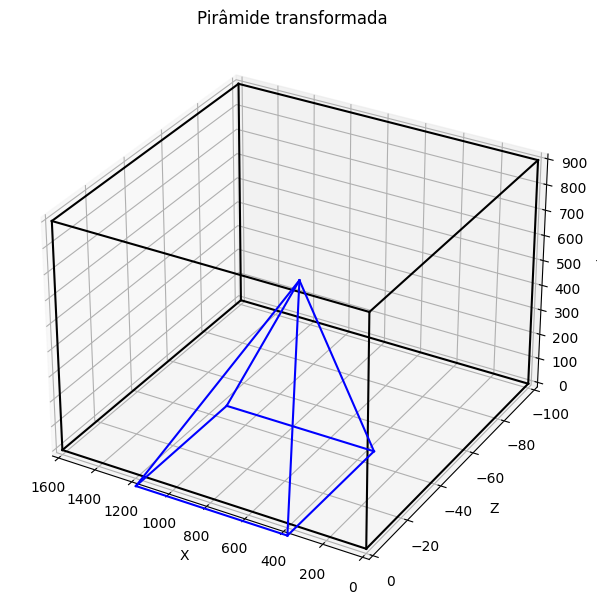

In [ ]:
figura = plt.figure(figsize=(16, 10))
eixo1 = figura.add_subplot(121, projection='3d')

apresentar_box()

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]
    eixo1.plot(
        [v1[0], v2[0]],
        [v1[2], v2[2]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide trasformada'
    )

eixo1.set_xlim(0, 1600)
eixo1.set_ylim(0, -100)
eixo1.set_zlim(0, 900)
eixo1.set_xlabel('X')
eixo1.set_ylabel('Z')
eixo1.set_zlabel('Y')
eixo1.set_title('Pirâmide transformada')
eixo1.invert_xaxis()


### Projeção em NDC

1.   Primeiro construir todos os vertices da pirâmide de forma homogênea, adicionando um quarto elemento, w=1
2. Em seguida, aplicando a matriz de projeção
3.  Por fim, normalizando, ou seja dividindo cada coordenada do vetor por seu respectivo novo valor de w.





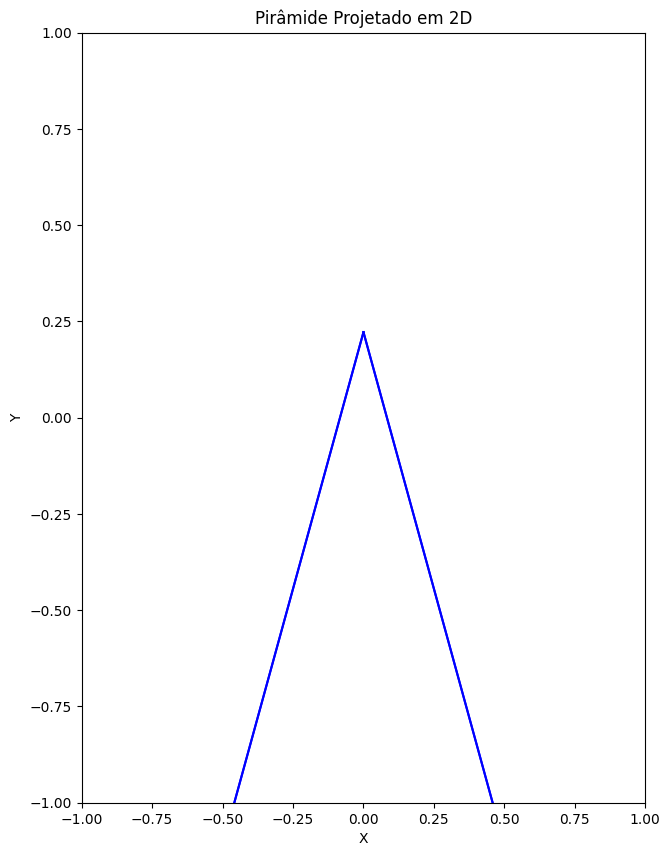

In [ ]:
def projetar_para_2d(vertice, matriz_projecao):
    vertice_homogeneo = np.append(vertice, 1)
    vertice_resultante = np.dot(matriz_projecao, vertice_homogeneo)
    x_2d = vertice_resultante[0] / vertice_resultante[3]
    y_2d = vertice_resultante[1] / vertice_resultante[3]
    return x_2d, y_2d

piramide2d_vertices = []


piramide2d_arestas = []

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]

    if (v1[2] >= -100 and v2[2] >= -100) and (v1[2] <= 0 and v2[2] <= 0):
        x1_2d, y1_2d = projetar_para_2d(v1, matriz_projecao)
        x2_2d, y2_2d = projetar_para_2d(v2, matriz_projecao)

        piramide2d_vertices.append([x1_2d, y1_2d])
        piramide2d_vertices.append([x2_2d, y2_2d])


        piramide2d_arestas.append([len(piramide2d_vertices) - 2, len(piramide2d_vertices) - 1])

piramide2d_vertices = np.array(piramide2d_vertices)


figura = plt.figure(figsize=(16, 10))
eixo2 = figura.add_subplot(122)


for aresta in piramide2d_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide2d_vertices[v1_idx]
    v2 = piramide2d_vertices[v2_idx]
    eixo2.plot(
        [v1[0], v2[0]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide em 2D'
    )

eixo2.set_xlim(-1, 1)
eixo2.set_ylim(-1, 1)
eixo2.set_xlabel('X')
eixo2.set_ylabel('Y')
eixo2.set_title('Pirâmide Projetado em 2D')
plt.show()

# ViewFrustom

## Ambiente de trabalho: ViewBox
Primeiro definimos o tamanho do viewbox, na proporção de 16:9 a ser utilizado com as coordenadas:

* Left: 0 & Right: 160
* Botton: 0 % Top: 90
* Near: -5 & Far: -50

In [ ]:
left = -80
right = 80
bottom = -45
top = 45
near = -5
far = -100

q = far / near

vertices = np.array([
    [left, bottom, near],           # Vértice 0
    [right, bottom, near],          # Vértice 1
    [right, top, near],             # Vértice 2
    [left, top, near],              # Vértice 3
    [left * q, bottom * q, far],        # Vértice 4
    [right * q, bottom * q, far],       # Vértice 5
    [right * q, top * q, far],          # Vértice 6
    [left * q, top * q, far]            # Vértice 7
])

O modelo a ser utilizado também será uma pirâmide

In [ ]:
def construir_piramide():
  arestas = [
    [0, 1], [1, 2], [2, 3], [3, 0],
    [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
  ]

  vertices = np.array([
      [20, -20, -10],
      [20, -20, -10],
      [40, -20, -10],
      [40, -20, -10],
      [30, 10, -10]
  ])

  piramide_arestas = [
      [0, 1],  [2, 0],
      [1, 3], [2, 3],
      [0, 4], [1, 4],
      [2, 4], [3, 4]
  ]

  return arestas, vertices, piramide_arestas

arestas, piramide_vertices, piramide_arestas = construir_piramide()

### Pirâmide no ViewFrustom
1. Plotar a figura que será utilizada
2. Seguido do ViewFrustom
3. Por fim a pirâmide

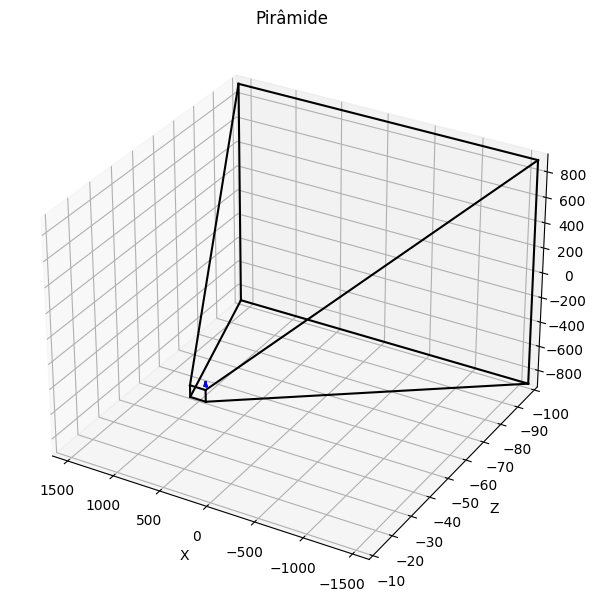

In [ ]:
figura = plt.figure(figsize=(16, 10))
eixo1 = figura.add_subplot(121, projection='3d')

apresentar_box()

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]
    eixo1.plot(
        [v1[0], v2[0]],
        [v1[2], v2[2]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide'
    )
eixo1.set_xlim(-1600, 1600)
eixo1.set_ylim(-10, -100)
eixo1.set_zlim(-900, 900)
eixo1.set_xlabel('X')
eixo1.set_ylabel('Z')
eixo1.set_zlabel('Y')
eixo1.set_title('Pirâmide')
eixo1.invert_xaxis()

### Matrizes de Transformações

Defindo os metodos que correspondes as transformações de translação, rotação, escalar e de projeção.

As transformações de translação, rotação e escalar já foram definidas, apenas é necessário definir a de projeção do viewfrustom.

In [ ]:
matriz_projecao_frustom = np.array([
    [2*near / (right - left), 0,  (right + left) / (right - left), 0],
    [0, 2 * near / (top - bottom), (top + bottom) / (top - bottom), 0],
    [0, 0,  -((far + near) / (far - near)), -(2*far*near/far-near)],
    [0, 0, -1, 0]
])

### Aplicando transformações

Para esse exemplo será aplicado uma rotação de 30° nos eixos x e z, uma translação em -50 no eixo z.

In [ ]:
rotacao = matriz_rotacao(30, 0, 30)
translacao = matriz_translacao(0, 0, -50)


resultado_transformacao = []

for vertice in piramide_vertices:
    #vertice = transformar_vertice(vertice, translacao)
    #vertice = transformar_vertice(vertice, rotacao)
    resultado_transformacao.append(vertice)

piramide_vertices = resultado_transformacao

Apresentação das transformações

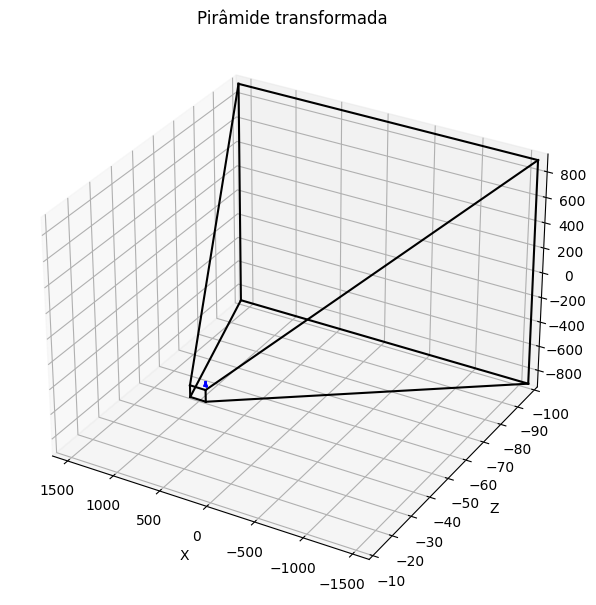

In [ ]:
figura = plt.figure(figsize=(16, 10))
eixo1 = figura.add_subplot(121, projection='3d')

apresentar_box()

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]
    eixo1.plot(
        [v1[0], v2[0]],
        [v1[2], v2[2]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide trasformada'
    )

eixo1.set_xlim(-1600, 1600)
eixo1.set_ylim(-10, -100)
eixo1.set_zlim(-900, 900)
eixo1.set_xlabel('X')
eixo1.set_ylabel('Z')
eixo1.set_zlabel('Y')
eixo1.set_title('Pirâmide transformada')
eixo1.invert_xaxis()



### Projeção em NDC

1.   Primeiro construir todos os vertices da pirâmide de forma homogênea, adicionando um quarto elemento, w=1
2. Em seguida, aplicando a matriz de projeção
3.  Por fim, normalizando, ou seja dividindo cada coordenada do vetor por seu respectivo novo valor de w.

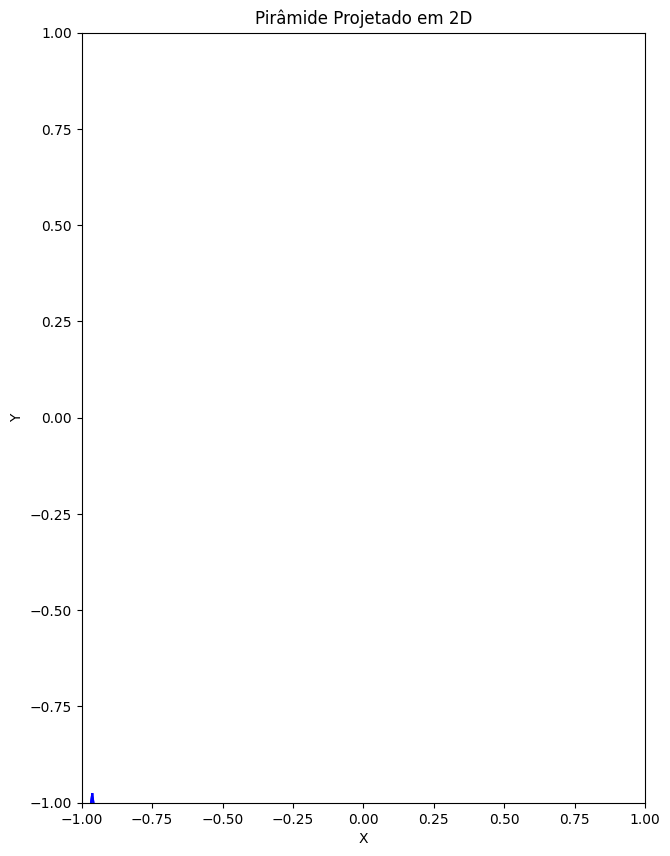

In [ ]:
def projetar_para_2d(vertice, matriz_projecao):
    vertice_homogeneo = np.append(vertice, 1)
    vertice_resultante = np.dot(matriz_projecao, vertice_homogeneo)
    x_2d = vertice_resultante[0] / vertice_resultante[3]
    y_2d = vertice_resultante[1] / vertice_resultante[3]
    return x_2d, y_2d

piramide2d_vertices = []
piramide2d_arestas = []

for aresta in piramide_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide_vertices[v1_idx]
    v2 = piramide_vertices[v2_idx]

    if (v1[2] >= -100 and v2[2] >= -100) and (v1[2] <= 0 and v2[2] <= 0):
        x1_2d, y1_2d = projetar_para_2d(v1, matriz_projecao)
        x2_2d, y2_2d = projetar_para_2d(v2, matriz_projecao)

        piramide2d_vertices.append([x1_2d, y1_2d])
        piramide2d_vertices.append([x2_2d, y2_2d])


        piramide2d_arestas.append([len(piramide2d_vertices) - 2, len(piramide2d_vertices) - 1])

piramide2d_vertices = np.array(piramide2d_vertices)


figura = plt.figure(figsize=(16, 10))
eixo2 = figura.add_subplot(122)


for aresta in piramide2d_arestas:
    v1_idx, v2_idx = aresta
    v1 = piramide2d_vertices[v1_idx]
    v2 = piramide2d_vertices[v2_idx]
    eixo2.plot(
        [v1[0], v2[0]],
        [v1[1], v2[1]],
        color='blue', label='Pirâmide em 2D'
    )

eixo2.set_xlim(-1, 1)
eixo2.set_ylim(-1, 1)
eixo2.set_xlabel('X')
eixo2.set_ylabel('Y')
eixo2.set_title('Pirâmide Projetado em 2D')
plt.show()